In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from pickle import load
import re
import math
import numpy as np
import matplotlib.pyplot as plt
import wandb
from loguru import logger
from train_config import CFG
import warnings
from tfswin import SwinTransformerV2Large256, preprocess_input
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

CFG = CFG()

2023-11-17 10:03:06.903519: I tensorflow/compiler/xla/stream_executor/tpu/tpu_initializer_helper.cc:269] Libtpu path is: libtpu.so
D1117 10:03:10.476046179    5040 config.cc:112]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1117 10:03:10.476068675    5040 config.cc:112]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1117 10:03:10.476073799    5040 config.cc:112]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1117 10:03:10.476078241    5040 config.cc:112]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1117 10:03:10.476082668    5040 config.cc:112]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1117 10:03:10.476086939    5040 config.cc:112]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1117 10:03:10.476091089

In [3]:
try:  # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='local')  # TPU detection
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:  # detect GPUs
    strategy = tf.distribute.get_strategy()  # default strategy that works on CPU and single GPU

REPLICAS = strategy.num_replicas_in_sync
print("Number of Accelerators: ", strategy.num_replicas_in_sync)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2023-11-17 10:03:38.189364: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x557573480f10 initialized for platform TPU (this does not guarantee that XLA will be used). Devices:
2023-11-17 10:03:38.189408: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): TPU, 2a886c8
2023-11-17 10:03:38.189420: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): TPU, 2a886c8
2023-11-17 10:03:38.189432: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): TPU, 2a886c8
2023-11-17 10:03:38.189443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): TPU, 2a886c8
2023-11-17 10:03:38.189454: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (4): TPU, 2a886c8
2023-11-17 10:03:38.189465: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (5): TPU, 2a886c8
2023-11-17 10:03:38.189476: I tensorflow/compiler/xla/service/service.cc:176]   StreamEx

INFO:tensorflow:Finished initializing TPU system.
INFO:tensorflow:Found TPU system:
INFO:tensorflow:*** Num TPU Cores: 8
INFO:tensorflow:*** Num TPU Workers: 1
INFO:tensorflow:*** Num TPU Cores Per Worker: 8
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)
INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)
I

In [7]:
REPLICAS = strategy.num_replicas_in_sync

In [19]:
def onehot(image,label):
    CLASSES = 467
    return image, tf.one_hot(label, CLASSES)

def cutmix(image, label, CFG, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with cutmix applied
    DIM = CFG.CROP_SIZE[0]
    CLASSES = 467
    
    imgs = []; labs = []
    for j in range(CFG.BATCH_SIZE):
        # DO CUTMIX WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.int32)
        # CHOOSE RANDOM IMAGE TO CUTMIX WITH
        k = tf.cast( tf.random.uniform([],0,CFG.BATCH_SIZE),tf.int32)
        # CHOOSE RANDOM LOCATION
        x = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        y = tf.cast( tf.random.uniform([],0,DIM),tf.int32)
        b = tf.random.uniform([],0,1) # this is beta dist with alpha=1.0
        WIDTH = tf.cast( DIM * tf.math.sqrt(1-b),tf.int32) * P
        ya = tf.math.maximum(0,y-WIDTH//2)
        yb = tf.math.minimum(DIM,y+WIDTH//2)
        xa = tf.math.maximum(0,x-WIDTH//2)
        xb = tf.math.minimum(DIM,x+WIDTH//2)
        # MAKE CUTMIX IMAGE
        one = image[j,ya:yb,0:xa,:]
        two = image[k,ya:yb,xa:xb,:]
        three = image[j,ya:yb,xb:DIM,:]
        middle = tf.concat([one,two,three],axis=1)
        img = tf.concat([image[j,0:ya,:,:],middle,image[j,yb:DIM,:,:]],axis=0)
        imgs.append(img)
        # MAKE CUTMIX LABEL
        a = tf.cast(WIDTH*WIDTH/DIM/DIM,tf.float32)
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(CFG.BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(CFG.BATCH_SIZE,CLASSES))
    return image2,label2

def mixup(image, label, CFG, PROBABILITY = 1.0):
    # input image - is a batch of images of size [n,dim,dim,3] not a single image of [dim,dim,3]
    # output - a batch of images with mixup applied
    DIM = CFG.CROP_SIZE[0]
    CLASSES = 467
    
    imgs = []; labs = []
    for j in range(CFG.BATCH_SIZE):
        # DO MIXUP WITH PROBABILITY DEFINED ABOVE
        P = tf.cast( tf.random.uniform([],0,1)<=PROBABILITY, tf.float32)
        # CHOOSE RANDOM
        k = tf.cast( tf.random.uniform([],0,CFG.BATCH_SIZE),tf.int32)
        a = tf.random.uniform([],0,1)*P # this is beta dist with alpha=1.0
        # MAKE MIXUP IMAGE
        img1 = image[j,]
        img2 = image[k,]
        imgs.append((1-a)*img1 + a*img2)
        # MAKE CUTMIX LABEL
        if len(label.shape)==1:
            lab1 = tf.one_hot(label[j],CLASSES)
            lab2 = tf.one_hot(label[k],CLASSES)
        else:
            lab1 = label[j,]
            lab2 = label[k,]
        labs.append((1-a)*lab1 + a*lab2)
            
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image2 = tf.reshape(tf.stack(imgs),(CFG.BATCH_SIZE,DIM,DIM,3))
    label2 = tf.reshape(tf.stack(labs),(CFG.BATCH_SIZE,CLASSES))
    return image2,label2

In [20]:
def get_model(res: int = [256, 256], num_classes: int = 467) -> tf.keras.Model:
    inputs = layers.Input(shape=(*res, 3), dtype='int8')
    outputs = SwinTransformerV2Large256(include_top=False, pooling='avg', input_shape=[*res, 3])(inputs)
    outputs = layers.Dense(num_classes, activation='softmax')(outputs)
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

In [32]:
def decode_image(image_data, CFG):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.image.resize_with_crop_or_pad(image, CFG.RAW_SIZE[0], CFG.RAW_SIZE[1])
    image = tf.image.random_crop(image, size=[*CFG.IMAGE_SIZE, 3])  #, method="lanczos5")
    return image

def read_labeled_tfrecord(example, CFG):
    LABELED_TFREC_FORMAT = {
        "image/encoded": tf.io.FixedLenFeature([], tf.string),
        "image/id": tf.io.FixedLenFeature([], tf.string),
        "image/meta/dataset": tf.io.FixedLenFeature([], tf.int64),
        "image/meta/longitude": tf.io.FixedLenFeature([], tf.float32),
        "image/meta/latitude": tf.io.FixedLenFeature([], tf.float32),
        "image/meta/date": tf.io.FixedLenFeature([], tf.string),
        "image/meta/class_priors": tf.io.FixedLenFeature([], tf.float32),
        "image/class/label": tf.io.FixedLenFeature([], tf.int64),
        "image/class/text": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image/encoded'], CFG)
    label = tf.cast(example['image/class/label'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, CFG, labeled = True, ordered = False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # Diregarding data order. Order does not matter since we will be shuffling the data anyway
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # use data as soon as it streams in, rather than in its original order
    dataset = dataset.map(lambda x: read_labeled_tfrecord(x, CFG) if labeled else read_unlabeled_tfrecord, num_parallel_calls = AUTO) # returns a dataset of (image, label) pairs if labeled = True or (image, id) pair if labeld = False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    return image, label   

def get_training_dataset(dataset, CFG, do_aug=True):
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.batch(CFG.BATCH_SIZE)
    if do_aug:
        dataset = dataset.map(lambda x, y: transform(x, y, CFG), num_parallel_calls=AUTO) # note we put AFTER batching
    dataset = dataset.unbatch()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(CFG.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(dataset, CFG, do_onehot=True):
    dataset = dataset.batch(CFG.BATCH_SIZE)
    if do_onehot: dataset = dataset.map(onehot, num_parallel_calls=AUTO) # we must use one hot like augmented train data
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def transform(image, label, CFG):
    # THIS FUNCTION APPLIES BOTH CUTMIX AND MIXUP
    DIM = CFG.CROP_SIZE[0]
    CLASSES = 467
    SWITCH = 0.5
    CUTMIX_PROB = 0.666
    MIXUP_PROB = 0.666
    # FOR SWITCH PERCENT OF TIME WE DO CUTMIX AND (1-SWITCH) WE DO MIXUP
    image2, label2 = cutmix(image, label, CFG, CUTMIX_PROB)
    image3, label3 = mixup(image, label, CFG, MIXUP_PROB)
    imgs = []; labs = []
    for j in range(CFG.BATCH_SIZE):
        P = tf.cast( tf.random.uniform([],0,1)<=SWITCH, tf.float32)
        imgs.append(P*image2[j,]+(1-P)*image3[j,])
        labs.append(P*label2[j,]+(1-P)*label3[j,])
    # RESHAPE HACK SO TPU COMPILER KNOWS SHAPE OF OUTPUT TENSOR (maybe use Python typing instead?)
    image4 = tf.reshape(tf.stack(imgs),(CFG.BATCH_SIZE, DIM, DIM,3))
    label4 = tf.reshape(tf.stack(labs),(CFG.BATCH_SIZE, CLASSES))
    return image4,label4

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)

    # In eager mode, iterate in the Datset directly.
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break
    return numpy_images, numpy_labels

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_from_dataset(dataset):
    subplot=331
    plt.figure(figsize=(13,13))
    images, labels = dataset_to_numpy_util(dataset, 9)
    for i, image in enumerate(images):
        title = class_dict[np.argmax(labels[i], axis=-1)]
        subplot = display_one_flower(image, title, subplot)
        if i >= 8:
            break

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

In [33]:
CFG.BATCH_SIZE =  REPLICAS * CFG.BASE_BATCH_SIZE

class_dict = load(open("class_dict.pkl", "rb"))

AUTO = tf.data.AUTOTUNE

GCS_PATH_SELECT = {
    192: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-192x192",
    224: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-224x224v2",
    256: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-256x256",
    384: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-384x384",
    512: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-512x512",
    None: f"gs://{CFG.GCS_REPO}/tfrecords-jpeg-raw",
}
GCS_PATH = GCS_PATH_SELECT[CFG.GCS_IMAGE_SIZE[0]]

filenames = tf.io.gfile.glob(f"{GCS_PATH}/train*.tfrec")
filenames, test_filenames = train_test_split(filenames, test_size=1)
training_filenames, validation_filenames = train_test_split(filenames, test_size=0.2, shuffle=True)

num_train = count_data_items(training_filenames)
num_val = count_data_items(validation_filenames)

In [34]:
row = 6; col = 4;
row = min(row,CFG.BATCH_SIZE//col)
all_elements = get_training_dataset(load_dataset(training_filenames, CFG), CFG, do_aug=False).unbatch()
augmented_element = all_elements.repeat().batch(CFG.BATCH_SIZE).map(lambda x, y: mixup(x, y, CFG))

for (img,label) in augmented_element:
    plt.figure(figsize=(15,int(15*row/col)))
    for j in range(row*col):
        plt.subplot(row,col,j+1)
        plt.axis('off')
        plt.imshow(img[j,])
    plt.show()
    break

AttributeError: in user code:

    File "/tmp/ipykernel_5040/3264567020.py", line 46, in None  *
        lambda x: read_labeled_tfrecord(x, CFG) if labeled else read_unlabeled_tfrecord
    File "/tmp/ipykernel_5040/3264567020.py", line 21, in read_labeled_tfrecord  *
        image = decode_image(example['image/encoded'], CFG)
    File "/tmp/ipykernel_5040/423776434.py", line 5, in decode_image  *
        image = tf.image.random_crop(image, size=[*CFG.IMAGE_SIZE, 3])  #, method="lanczos5")

    AttributeError: 'CFG' object has no attribute 'IMAGE_SIZE'


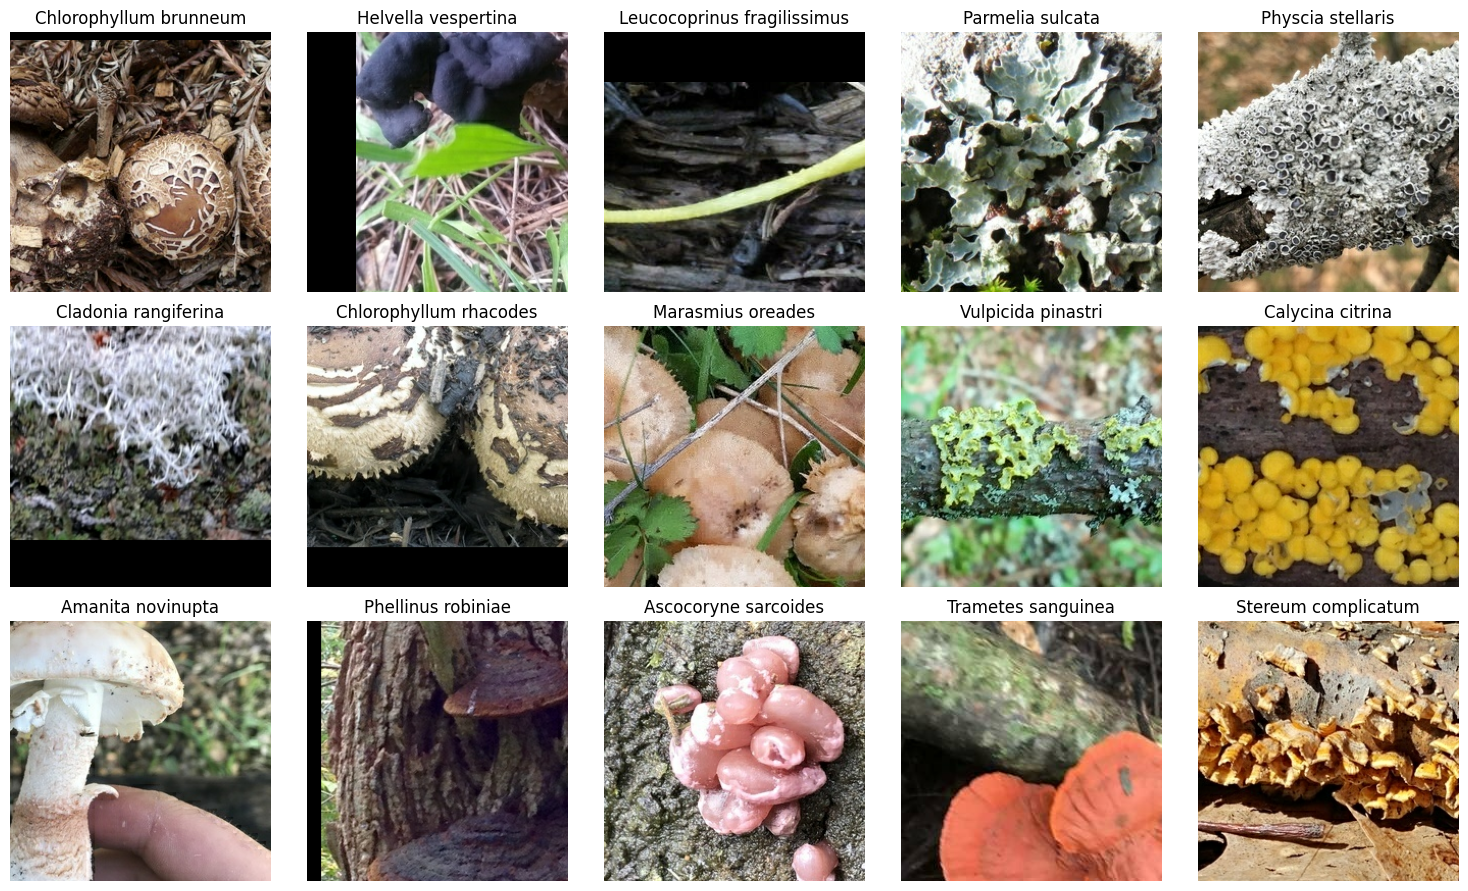

In [18]:
sample_images, sample_labels = next(iter(get_batched_dataset(training_filenames, CFG, train=True)))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n]).numpy()
    # image = image[:, :, ::-1]
    # image = (image - image.min()) / (
    #     image.max() - image.min()
    # )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(class_dict[sample_labels.numpy()[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [15]:
sample_images

<tf.Tensor: shape=(256, 256, 256, 3), dtype=float32, numpy=
array([[[[116., 111., 105.],
         [117., 112., 106.],
         [121., 114., 108.],
         ...,
         [ 84.,  75.,  66.],
         [ 85.,  75.,  65.],
         [ 88.,  78.,  68.]],

        [[109., 104.,  98.],
         [112., 105.,  99.],
         [111., 102.,  97.],
         ...,
         [ 82.,  73.,  64.],
         [ 82.,  72.,  63.],
         [ 84.,  74.,  64.]],

        [[ 97.,  90.,  84.],
         [100.,  93.,  87.],
         [102.,  93.,  86.],
         ...,
         [ 78.,  69.,  60.],
         [ 70.,  60.,  51.],
         [ 72.,  59.,  51.]],

        ...,

        [[158., 152., 130.],
         [164., 159., 140.],
         [170., 168., 153.],
         ...,
         [125., 101.,  77.],
         [113.,  91.,  68.],
         [104.,  82.,  59.]],

        [[168., 161., 142.],
         [173., 167., 151.],
         [166., 164., 151.],
         ...,
         [113.,  88.,  66.],
         [102.,  80.,  59.],
       

In [8]:
CFG.TOTAL_STEPS = int((num_train / CFG.BATCH_SIZE) * CFG.EPOCHS - 1)
validation_steps = num_val // CFG.BATCH_SIZE
steps_per_epoch = num_train // CFG.BATCH_SIZE

CFG.WARMUP_STEPS = steps_per_epoch * 5
CFG.DECAY_STEPS = steps_per_epoch * (CFG.EPOCHS - CFG.WARMUP_STEPS)

In [9]:
with strategy.scope(): # this line is all that is needed to run on TPU (or multi-GPU, ...)
    lr_rate = keras.optimizers.schedules.CosineDecay(CFG.LR_START, warmup_steps=CFG.WARMUP_STEPS, decay_steps=CFG.DECAY_STEPS, alpha=CFG.ALPHA, warmup_target=CFG.WARMUP_TARGET)
    optimizer = keras.optimizers.AdamW(lr_rate)
    loss = keras.losses.SparseCategoricalCrossentropy()
    model = get_model(res=CFG.CROP_SIZE, num_classes=len(class_dict))
    model.compile(loss=loss, optimizer=optimizer, metrics=[
        "accuracy",
        keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy")
        ])

2023-11-17 08:16:03.979751: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-17 08:16:05.151771: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


787429584/787429584 [==============================] - 4s 0us/step


In [13]:
config=wandb.helper.parse_config(
    CFG, 
    include=(
        'ALPHA', 'AUGMENT', 'BATCH_SIZE', 'EPOCHS', 'ES_PATIENCE', 'GCS_IMAGE_SIZE', 'DECAY_STEPS',
        'LR_START', 'MODEL_SIZE', 'SEED', 'TTA', 'TOTAL_STEPS', 'WARMUP_STEPS', 'WARMUP_TARGET',
        'RAW_SIZE', 'CROP_SIZE', 'RAW_SIZE'
    )
)
wandb.init(
    project="Mushroom-Classifier",
    tags=[CFG.MODEL, CFG.OPT, CFG.LR_SCHED, str(CFG.CROP_SIZE[0])],
    config=config,
    dir="../",
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: g-broughton. Use `wandb login --relogin` to force relogin


In [14]:
CFG.CKPT_DIR.mkdir(parents=True, exist_ok=True)
callbacks = [
    wandb.keras.WandbMetricsLogger(log_freq="batch"),
    wandb.keras.WandbModelCheckpoint(
        str(CFG.CKPT_DIR),  # .h5 for weights, dir for whole model
        monitor="val_accuracy",  #monitor=CFG.ES_MONITOR
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        # options=options,
        initial_value_threshold=0.6,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=CFG.ES_PATIENCE, restore_best_weights=True
    ),
]

wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [15]:
tr_ds = get_batched_dataset(training_filenames, CFG, train=True)
val_ds = get_batched_dataset(validation_filenames, CFG)

history = model.fit(
    tr_ds, 
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    # validation_steps=validation_steps,
    epochs=CFG.EPOCHS, 
    callbacks=callbacks
    )

Epoch 1/40


2023-11-17 08:21:33.015837: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:3483922001024013407
2023-11-17 08:21:44.423681: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-17 08:21:49.173021: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AdamW/AssignAddVariableOp.
2023-11-17 08:21:58.256648: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(1391990698365546738:0:0), session_name()
2023-11-17 08:24:03.866756: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 1391990698365546738:0:0 with session name  took 2m5.609973133s and succeeded
2023-11-17 08:24:04.189122: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host 

315/315 [==============================] - ETA: 0s - loss: 2.8016 - accuracy: 0.3974 - top-3-accuracy: 0.5785

2023-11-17 08:30:29.210925: I tensorflow/core/tpu/graph_rewrite/encapsulate_tpu_computations_pass.cc:238] Subgraph fingerprint:3147987398945661230
2023-11-17 08:30:32.049478: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-17 08:30:33.362296: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-11-17 08:30:35.798092: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:437] TPU host compilation cache miss: cache_key(13184445192755667303:0:0), session_name()
2023-11-17 08:31:07.343309: I tensorflow/core/tpu/kernels/tpu_compile_op_common.cc:221] Compilation of 13184445192755667303:0:0 with session name  took 31.545138665s and succeeded
2023-11-17 08:31:07.434306: I tensorflow/core/tpu/kernels/tpu_compilation_cache_interface.cc:471] TPU host compilation


Epoch 1: val_loss improved from 2.00000 to 1.58707, saving model to /home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811
INFO:tensorflow:Assets written to: /home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811/assets


INFO:tensorflow:Assets written to: /home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811/assets
wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 31.0s


315/315 [==============================] - 1002s 2s/step - loss: 2.8016 - accuracy: 0.3974 - top-3-accuracy: 0.5785 - val_loss: 1.5871 - val_accuracy: 0.5806 - val_top-3-accuracy: 0.7897
Epoch 2/40
315/315 [==============================] - ETA: 0s - loss: 1.8747 - accuracy: 0.5257 - top-3-accuracy: 0.7385
Epoch 2: val_loss did not improve from 1.58707


wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 26.3s


315/315 [==============================] - 427s 1s/step - loss: 1.8747 - accuracy: 0.5257 - top-3-accuracy: 0.7385 - val_loss: 1.7541 - val_accuracy: 0.5489 - val_top-3-accuracy: 0.7604
Epoch 3/40
315/315 [==============================] - ETA: 0s - loss: 1.7124 - accuracy: 0.5600 - top-3-accuracy: 0.7665
Epoch 3: val_loss did not improve from 1.58707


wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 25.9s


315/315 [==============================] - 427s 1s/step - loss: 1.7124 - accuracy: 0.5600 - top-3-accuracy: 0.7665 - val_loss: 1.6593 - val_accuracy: 0.5734 - val_top-3-accuracy: 0.7805
Epoch 4/40
315/315 [==============================] - ETA: 0s - loss: 1.4639 - accuracy: 0.6092 - top-3-accuracy: 0.8120
Epoch 4: val_loss did not improve from 1.58707


wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 26.2s


315/315 [==============================] - 433s 1s/step - loss: 1.4639 - accuracy: 0.6092 - top-3-accuracy: 0.8120 - val_loss: 1.6390 - val_accuracy: 0.5785 - val_top-3-accuracy: 0.7871
Epoch 5/40
315/315 [==============================] - ETA: 0s - loss: 1.3149 - accuracy: 0.6423 - top-3-accuracy: 0.8363
Epoch 5: val_loss did not improve from 1.58707


wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 26.0s


315/315 [==============================] - 428s 1s/step - loss: 1.3149 - accuracy: 0.6423 - top-3-accuracy: 0.8363 - val_loss: 1.5965 - val_accuracy: 0.5846 - val_top-3-accuracy: 0.7885
Epoch 6/40
315/315 [==============================] - ETA: 0s - loss: 1.1973 - accuracy: 0.6675 - top-3-accuracy: 0.8563
Epoch 6: val_loss did not improve from 1.58707


wandb: Adding directory to artifact (/home/broug/Mushroom-Classifier/models/swinv2_large_256/1117-0811)... Done. 26.0s


315/315 [==============================] - 437s 1s/step - loss: 1.1973 - accuracy: 0.6675 - top-3-accuracy: 0.8563 - val_loss: 1.5913 - val_accuracy: 0.5977 - val_top-3-accuracy: 0.7960


In [16]:
wandb.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch/accuracy,▁▂▃▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▂▂▃▃▄▄▅▅▆▆▇████████████████████████████
batch/loss,█▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/top-3-accuracy,▁▂▄▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████
epoch/accuracy,▁▄▅▆▇█
epoch/epoch,▁▂▄▅▇█
epoch/learning_rate,▁█████
epoch/loss,█▄▃▂▂▁
epoch/top-3-accuracy,▁▅▆▇▇█
epoch/val_accuracy,▆▁▅▅▆█
